In [ ]:
from eolearn.features import InterpolationTask

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib.animation as animation


import pickle as pkl

from enum import Enum

from sentinelhub import CRS, BBoxSplitter, BBox

from shapely.geometry import Polygon

from eolearn.io.local_io import *
from contextlib import contextmanager  

import rasterio
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling


# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadFromDisk, SaveToDisk, EOExecutor
from eolearn.io import S2L1CWCSInput, ExportToTiff
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

%matplotlib inline

/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
indexes = [[0,1,4],
               [3,7],
               [2,6], 
                 [5,9,11],
                   [8,10]]

places  = [[1,  2,  3],
                   [9 , 10],
                   [15, 16], 
                       [22 , 23, 24],
                            [29, 30]]

patchIDs = [0,1,2,3,4,5,6,7,8,9,10,11]

path_out = './eopatches-large/'

In [4]:
class ConcatenateData(EOTask):
    """ Task to concatenate data arrays along the last dimension
    """
    def __init__(self, feature_name, feature_names_to_concatenate):
        self.feature_name = feature_name
        self.feature_names_to_concatenate = feature_names_to_concatenate

    def execute(self, eopatch):
        arrays = [eopatch.data[name] for name in self.feature_names_to_concatenate]

        eopatch.add_feature(FeatureType.DATA, self.feature_name, 
                            np.concatenate(arrays, axis=-1))

        return eopatch
    
    
    
class ValidDataFractionPredicate:
    """ Predicate that defines if a frame from EOPatch's time-series is valid or not. 
    Frame is valid, if the 
    valid data fraction is above the specified threshold.
    """
    def __init__(self, threshold):
        self.threshold = threshold
        
    def __call__(self, array):
        coverage = np.sum(array.astype(np.uint8)) / np.prod(array.shape)
        return coverage > self.threshold

In [5]:
# TASK TO LOAD EXISTING EOPATCHES
load = LoadFromDisk(path_out)

# TASK FOR CONCATENATION
concatenate = ConcatenateData('FEATURES', ['BANDS', 'NDVI', 'NDWI', 'NORM'])

# TASK FOR FILTERING OUT TOO CLOUDY SCENES
# keep frames with > 80 % valid coverage
valid_data_predicate = ValidDataFractionPredicate(0.8)
filter_task = SimpleFilterTask((FeatureType.MASK, 'IS_VALID'), valid_data_predicate)

# TASK FOR LINEAR INTERPOLATION
# linear interpolation of full time-series and date resampling

resampled_range = ('2017-01-01', '2017-8-20', 29)
linear_interp = LinearInterpolation(
    'FEATURES', # name of field to interpolate
    mask_feature=(FeatureType.MASK, 'IS_VALID'), # mask to be used in interpolation
    copy_features=[(FeatureType.MASK_TIMELESS, 'LULC')], # features to keep
    resample_range=resampled_range, # set the resampling range
    bounds_error=False # extrapolate with NaN's
)

# TASK FOR EROSION
# erode each class of the reference map
erosion = ErosionTask(mask_feature=(FeatureType.MASK_TIMELESS,'LULC','LULC_ERODED'), disk_radius=1)

# TASK FOR SPATIAL SAMPLING
# Uniformly sample about pixels from patches
n_samples = int(1e5) # no. of pixels to sample
ref_labels = [1,2,3,4,5,6,7,8,9] # reference labels to take into account when sampling

# spatial_sampling = PointSamplingTask(
#     n_samples=n_samples, 
#     ref_mask_feature='LULC_ERODED', 
#     ref_labels=ref_labels, 
#     sample_features=[  # tag fields to sample
#         (FeatureType.DATA, 'FEATURES'),
#         (FeatureType.MASK_TIMELESS, 'LULC_ERODED')
#     ])

path_out_sampled = './eopatches_interpolated_large/'
if not os.path.isdir(path_out_sampled):
    os.makedirs(path_out_sampled)
save = SaveToDisk(path_out_sampled, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

In [6]:
# Define the workflow
workflow = LinearWorkflow(
    load,
    concatenate,
    filter_task,
    linear_interp,
    #erosion,
    #spatial_sampling,
    save
)

In [ ]:
# %%time
   
# execution_args = []
# for idx in range(len(patchIDs)):
#     execution_args.append({
#         load: {'eopatch_folder': 'eopatch_{}'.format(idx)},
#         save: {'eopatch_folder': 'eopatch_{}'.format(idx)}
#     })
    
# executor = EOExecutor(workflow, execution_args, save_logs=True)
# executor.run(workers=5, multiprocess=True)

# executor.make_report()

### Sample from patches

In [7]:
def save_samples(patch_path, patch_idx, out_path, size=64, sample_factor=25):
    
    patch_path = Path(patch_path)
    out_path = Path(out_path)
    
    out_path.mkdir(exist_ok=True, parents=True)
    
    patch = EOPatch.load(patch_path/f'eopatch_{patch_idx}')
    
    half_size = size//2
    
    targets = patch.mask_timeless['LULC']
    
    patch_shape = targets.shape
    
    shape_x = patch_shape[0]
    shape_y = patch_shape[1]
    
    features = patch.data['FEATURES'][...,[3,2,1,8,-3,-1]] # R G B NIR NDVI NORM
    
    features[7][np.isnan(features[7])] = features[6][np.isnan(features[7])]
    
    non_empty_targets = np.indices(patch_shape)[:,targets!=0]
    
    target_xs = non_empty_targets[0]
    target_ys = non_empty_targets[1]

    target_count = len(target_xs)
    
    samples = (target_count*sample_factor)//(size**2)
    
    #print(f'saving {samples} patchlets from patch {patch_idx}')

    for i in range(samples):
        index = np.random.randint(target_count)
        
        x_offset = np.clip(target_xs[index], half_size, shape_x-half_size) # ensure sample won't exceed patch
        y_offset = np.clip(target_ys[index], half_size, shape_y-half_size) # ensure sample won't exceed patch
        
        targ_arr = targets [x_offset-half_size:x_offset+half_size, y_offset-half_size:y_offset+half_size,0]
        feat_arr = features[:,x_offset-half_size:x_offset+half_size, y_offset-half_size:y_offset+half_size,:]
        
        targ_fn = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_targ.pkl'
        feat_fn = f'patch_{patch_idx}_x_{x_offset}_y_{y_offset}_feat.pkl'
        
        pkl.dump(targ_arr, open(out_path/targ_fn,'wb'))
        pkl.dump(feat_arr, open(out_path/feat_fn,'wb'))
    
    del patch

In [8]:
from tqdm import tqdm

In [10]:
patchlet_path=Path('./training_patchlets')

In [11]:
for patch_idx in tqdm(range(12)):
    save_samples(patch_path='./eopatches_interpolated_large', 
                 patch_idx=patch_idx, 
                 out_path=patchlet_path, 
                 size=64, 
                 sample_factor=25)

100%|██████████| 12/12 [06:09<00:00, 19.26s/it]


In [12]:
len([str(f) for f in patchlet_path.glob('*_targ.pkl')])

5724

Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


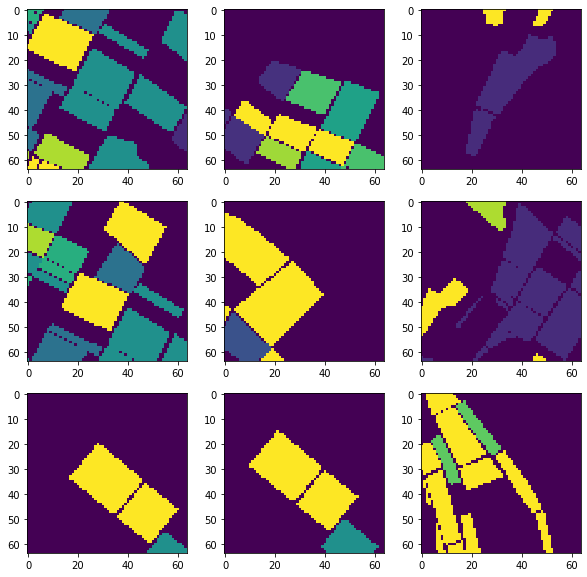

In [17]:
%matplotlib inline

targs = [str(f) for f in patchlet_path.glob('patch_10_*_targ.pkl')][:9]

fig = plt.figure(figsize=(10,10))

for i,f in enumerate(targs):
    ax = plt.subplot(3, 3, i+1)
    targ = pkl.load(open(f,'rb'))
    plt.imshow(targ)

<IPython.core.display.Javascript object>


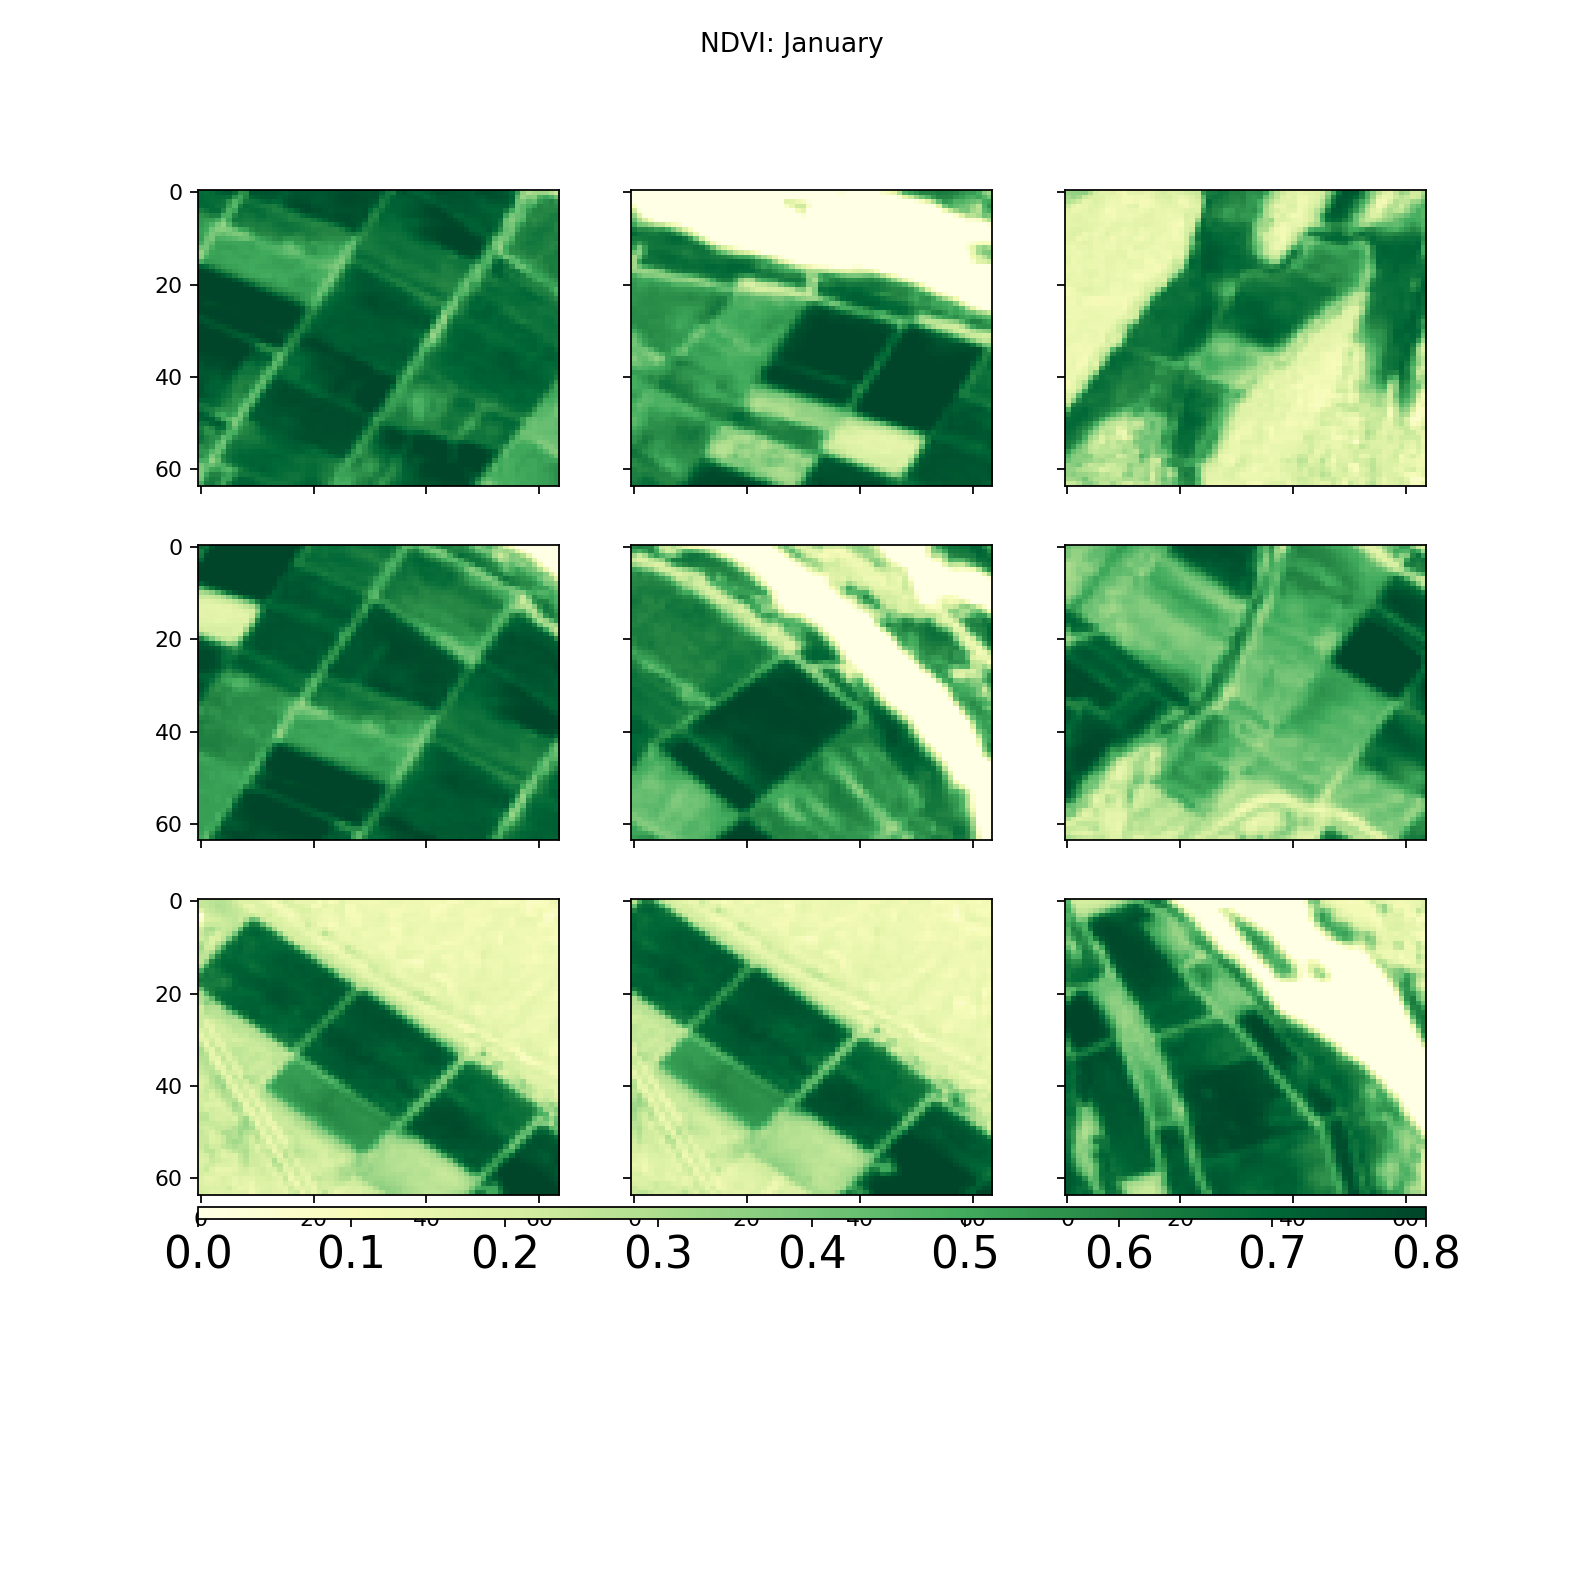

In [18]:
# Usually we use `%matplotlib inline`. However we need `notebook` for the anim to render in the notebook.
%matplotlib notebook

fps = 1
nSeconds = 8

fig, axes = plt.subplots(3,3,sharey=True,sharex=True, figsize=(10,10))

feats = [str(f).replace('targ','feat') for f in targs]

datas = [[pkl.load(open(feat,'rb'))[i,...,-2] for i in range(8)] for feat in feats]

imgs = [axes[j//3,j%3].imshow(datas[j][0], interpolation='none', aspect='auto', 
                              vmin=0, vmax=0.8, cmap=plt.get_cmap('YlGn'))
      for j in range(len(feats))]

cb = fig.colorbar(imgs[0], ax=axes.ravel().tolist(), orientation='horizontal', pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=20)

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
def animate_func(i):
    fig.suptitle(f'NDVI: {months[i]}')
    for j in range(len(feats)):
        imgs[j].set_array(datas[j][i])
    return [imgs]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('nvdi.gif', writer=mpl.animation.PillowWriter(fps=fps))

Traceback (most recent call last):
  File "/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 216, in process
    func(*args, **kwargs)
  File "/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


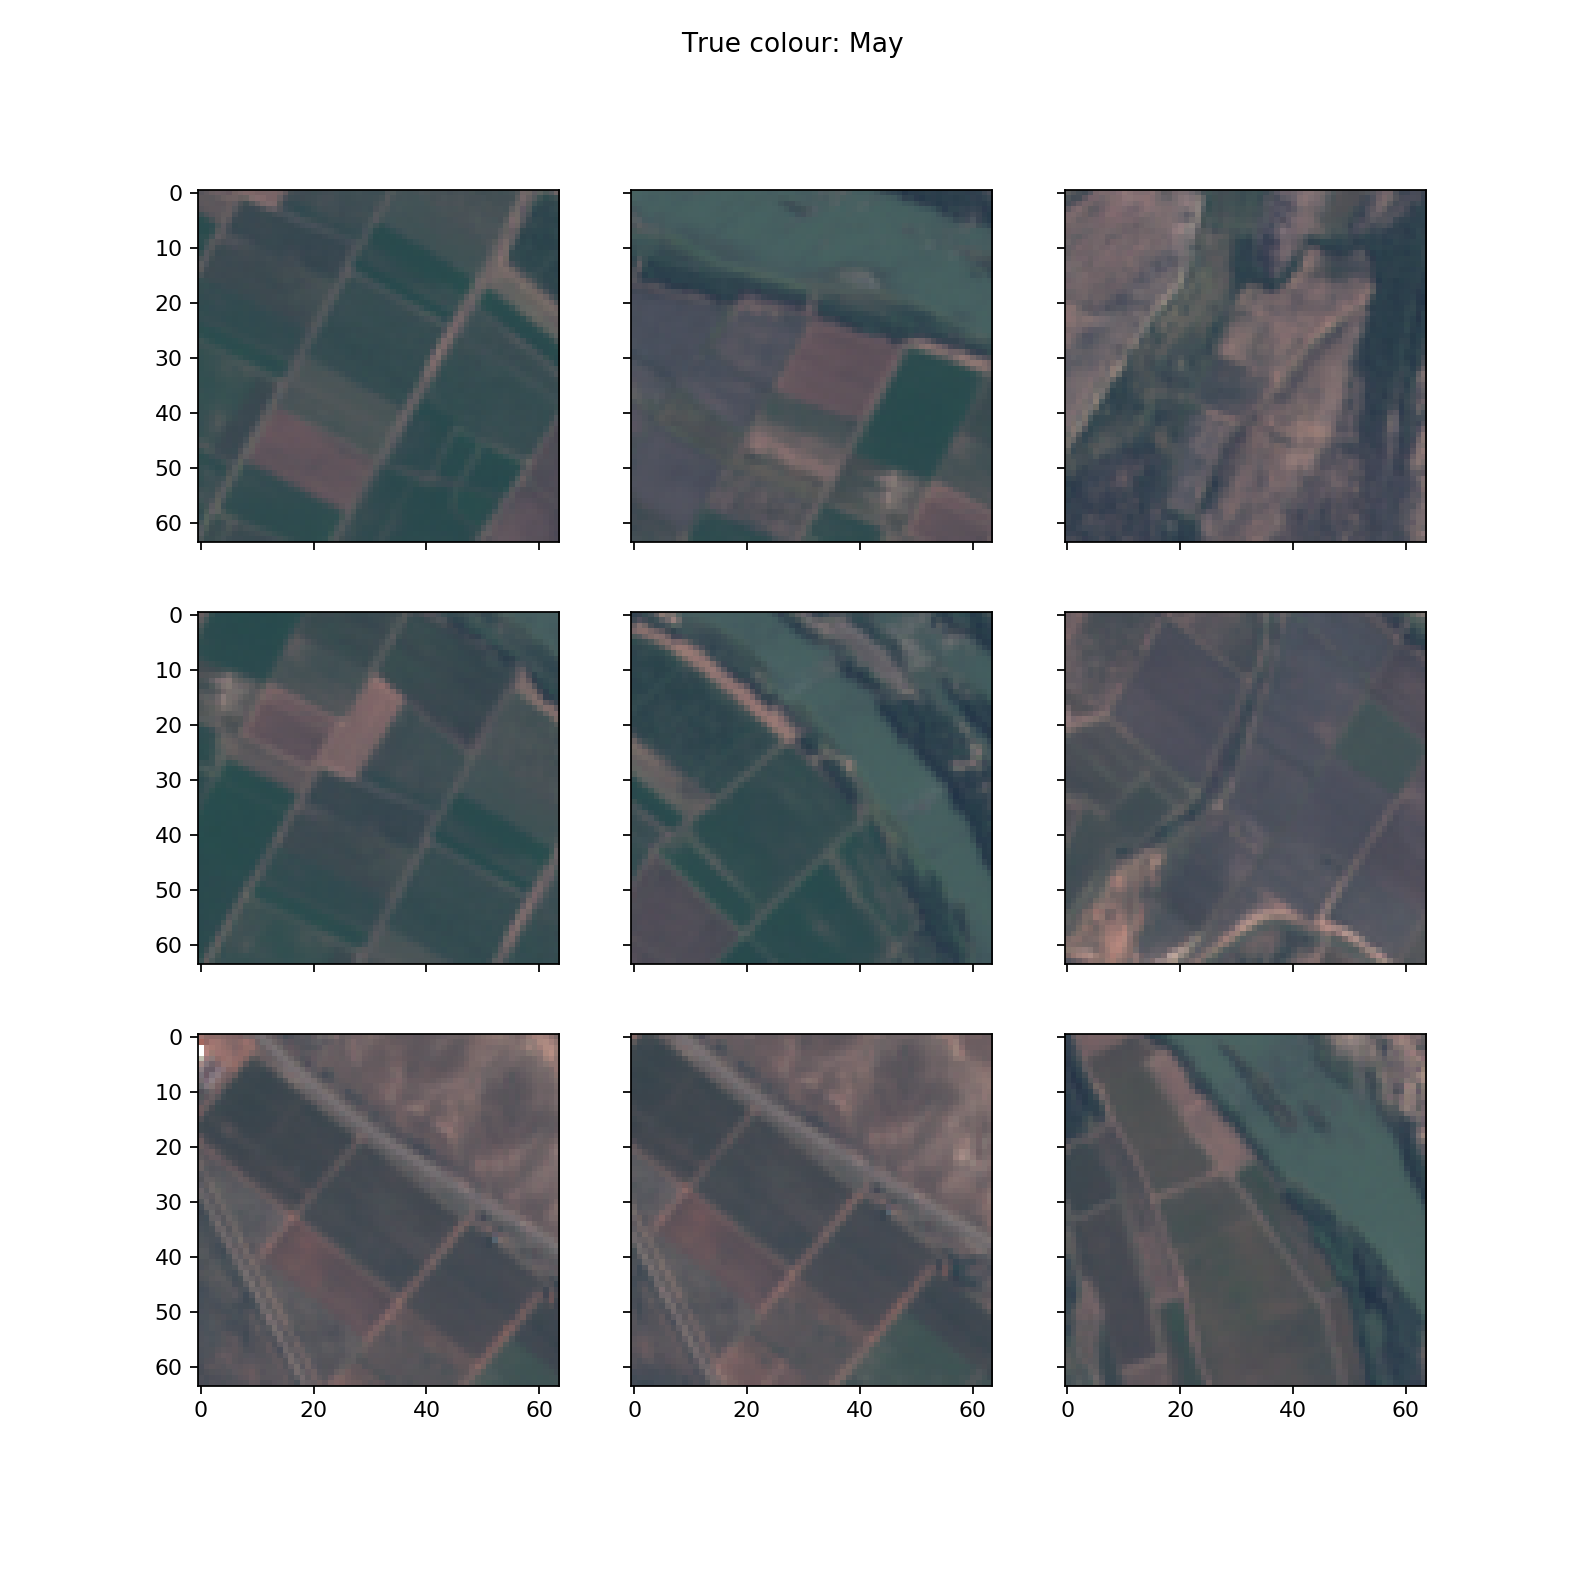

In [19]:
# Usually we use `%matplotlib inline`. However we need `notebook` for the anim to render in the notebook.
%matplotlib notebook

fps = 1
nSeconds = 8

fig, axes = plt.subplots(3,3,sharey=True,sharex=True, figsize=(10,10))

feats = [str(f).replace('targ','feat') for f in targs]

datas = [[np.clip(pkl.load(open(feat,'rb'))[i,...,0:3]*3.5,0,1) for i in range(8)] for feat in feats]

imgs = [axes[j//3,j%3].imshow(datas[j][0], interpolation='none', aspect='auto', cmap=plt.get_cmap('YlGn'), vmin=0, vmax=1) 
      for j in range(len(feats))]

months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']
def animate_func(i):
    fig.suptitle(f'True colour: {months[i]}')
    for j in range(len(feats)):
        imgs[j].set_array(datas[j][i])
    return [imgs]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )

anim.save('nvdi.gif', writer=mpl.animation.PillowWriter(fps=fps))

